## TP Climate Finance

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from scipy.optimize import minimize, LinearConstraint

### Importing data

---

In [2]:
df_stock=pd.read_excel("Individual_stock_data.xlsx",sheet_name='stock prices').dropna(axis=1)
df_stock=df_stock.set_index('Date')
df_stock.index=pd.to_datetime(df_stock.index)
df_carbonfootprint=pd.read_excel("Individual_stock_data.xlsx",sheet_name='carbon footprint data')
df_sp=pd.read_excel('Individual_stock_data.xlsx',sheet_name='SP500')
df_sp=df_sp.set_index('Name')

Positive screening

In [3]:
df_50best=df_stock.filter(items=list(df_carbonfootprint.sort_values("INTENSITY").iloc[:96,0]),axis=1)

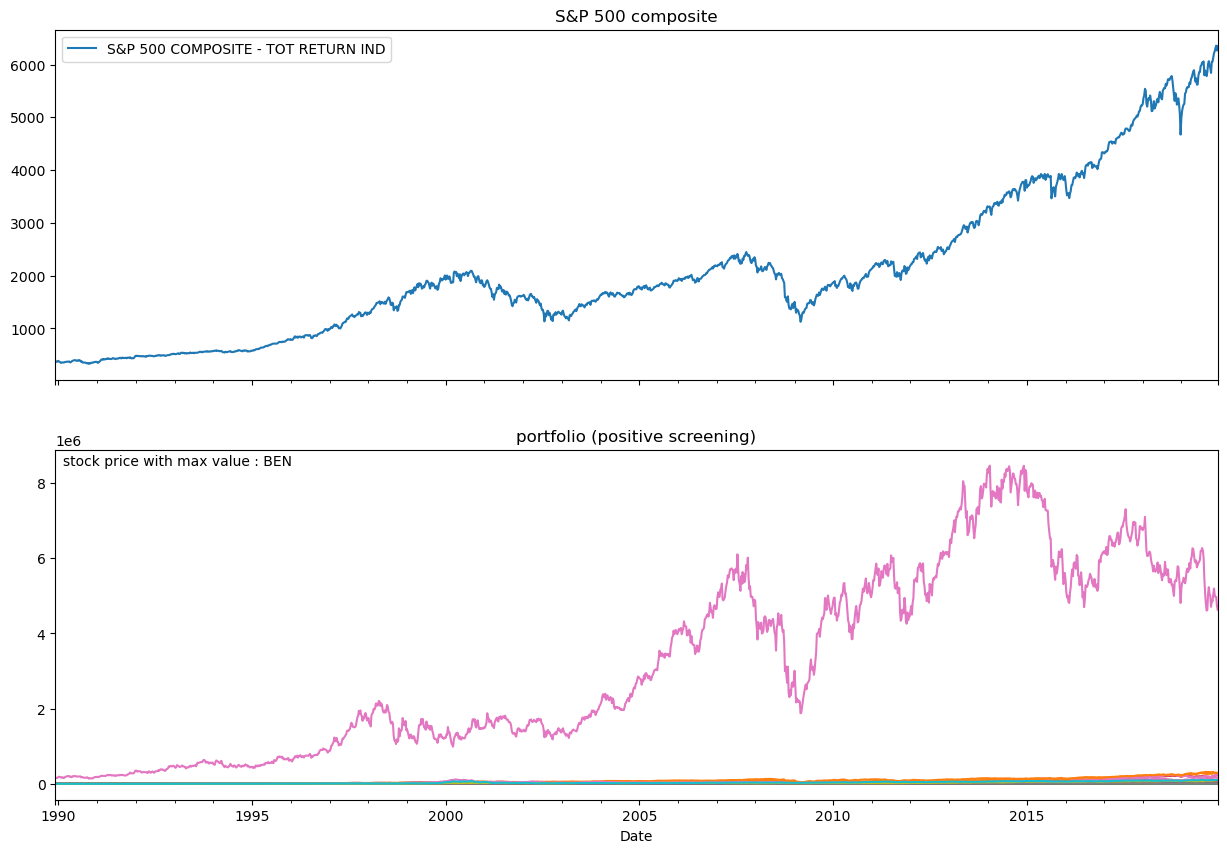

In [4]:
fig,ax=plt.subplots(2,1,figsize=(15,10),sharex=True)
df_sp.plot(ax=ax[0], title='S&P 500 composite')
ax=df_50best.plot(ax=ax[1],legend=False,title='portfolio (positive screening)')
ax.text(df_50best.index[10],df_50best.max(axis=0).max(),"stock price with max value : "+f"{df_50best.max(axis=0).idxmax()}")
plt.show()

### Standard risk and return indicators

---

In [5]:
def sharpe_ratio(portfolio_returns, risk_free_rate, periods_per_year):
    
    # Calculate the mean and standard deviation of the portfolio returns
    portfolio_mean = portfolio_returns.mean()
    portfolio_std_dev = portfolio_returns.std()
    
    # Calculate the Sharpe ratio
    sharpe_ratio = (portfolio_mean - risk_free_rate) / (portfolio_std_dev * np.sqrt(periods_per_year))
    
    return sharpe_ratio

In [6]:

def tracking_error(portfolio_returns, benchmark_returns):

    # Calculate the difference in returns between the portfolio and the benchmark
    diff_returns = portfolio_returns - benchmark_returns
    
    # Calculate the tracking error as the standard deviation of the difference in returns
    tracking_error = diff_returns.std()
    
    return tracking_error

In [7]:
def annualized_volatility(portfolio_returns, periods_per_year):
    
    # Calculate the standard deviation of the portfolio returns
    portfolio_std_dev = portfolio_returns.std()
    
    # Calculate the annualized volatility
    annualized_volatility = portfolio_std_dev * np.sqrt(periods_per_year)
    
    return annualized_volatility

### Returns

---

$$ Return \quad R_i = \begin{cases} (\frac{s_i-s_{i-1}}{s_{i-1}} \quad si \quad i \in [t_1,...,t_n]\\ 0 \quad si \quad i=t_0 \end{cases}$$

In [8]:
def add_return(df):
    iduree=[i for i in range(len(df.index))]
    del iduree[0]        #we exclude the 1st time
    df=df.copy()
    columns=[f'Return {c}' for c in df.columns]
#construction of a dataframe named "dfr" filled with zeros that will contain the values of the returns :
    dfr=pd.DataFrame(np.zeros((len(df.index),len(columns))),columns=columns) 
    for c in df.columns :
#computation of the values of the returns :
        for i in iduree :
            dfr.loc[i,f'Return {c}']=(df.loc[df.index[i],c]-df.loc[df.index[i]-np.timedelta64(7, 'D'),c])/df.loc[df.index[i]-np.timedelta64(7, 'D'),c]
#set to zero the values of the returns for the first instant :
        dfr.loc[0,f'Return {c}']=0
    dfr.index=df.index
#Return the concatenation of the initial dataframe "df" and "dfr" which contains the calculated values :
    return pd.concat([df,dfr],axis=1)       

Computation of returns for 50 best stocks

In [9]:
%%time
df_50best=add_return(df_50best)

Wall time: 11.2 s


In [10]:
df_sp=add_return(df_sp)

In [11]:
print(f"Indicators for S&P 500 :\nExpected return = {df_sp['Return S&P 500 COMPOSITE - TOT RETURN IND'].mean()}\
\nAnnualized volatility = {annualized_volatility(df_sp['Return S&P 500 COMPOSITE - TOT RETURN IND'],52)}\
\nSharpe ratio = {sharpe_ratio(df_sp['Return S&P 500 COMPOSITE - TOT RETURN IND'],0,52)}\
\nTracking Error = {tracking_error(df_sp['Return S&P 500 COMPOSITE - TOT RETURN IND'],df_sp['Return S&P 500 COMPOSITE - TOT RETURN IND'])}")

Indicators for S&P 500 :
Expected return = 0.0020519532180956687
Annualized volatility = 0.15894223942091032
Sharpe ratio = 0.012910056040305894
Tracking Error = 0.0


In [12]:
print(f"Indicators for portfolio without any strategy :\nExpected return = {df_50best.iloc[:,50:100].mean(axis=1).mean()}\
\nAnnualized volatility = {annualized_volatility(df_50best.iloc[:,50:100].mean(axis=1),52)}\
\nSharpe ratio = {sharpe_ratio(df_50best.iloc[:,50:100].mean(axis=1),0,52)}\
\nTracking Error = {tracking_error(df_50best.iloc[:,50:100].mean(axis=1),df_sp['Return S&P 500 COMPOSITE - TOT RETURN IND'])}")

Indicators for portfolio without any strategy :
Expected return = 0.0036114414405884468
Annualized volatility = 0.20152022683214305
Sharpe ratio = 0.017920987373622844
Tracking Error = 0.010661608489073895


### Weight search by minimizing tracking error

---

Division of the time horizon each 3 years (+ 4 weeks because data begin the 5th december of 1989)

In [13]:
interval0=df_50best.index[(df_50best.index < '1993-01-01')]
T=len(interval0)
NbT=int(len(df_50best)/T)
print(f"Number of time intervals = {NbT}\nSize of first interval = {T}")
df_carbonfootprint=df_carbonfootprint.set_index('ID')

Number of time intervals = 9
Size of first interval = 161


Dynamic time interval

In [14]:
def Intervalle(i):
    I=df_50best.index[(df_50best.index < '1993-01-01')]
    if i==NbT:
        I=df_50best.index[(df_50best.index > Intervalle(NbT-1).max())]
    if 0<i<NbT:
        I=df_50best.index[(df_50best.index > Intervalle(i-1).max())&(df_50best.index < Intervalle(i-1).max()+np.timedelta64(T+1, 'W'))]
    return I

Optimization problem : minimization of tracking error with a 50% carbon footprint reduction constraint 

$$  \min  \sqrt{\frac{\sum^N (w.R_i-sp_i)^2}{N}}$$
s.t.
$$ \sum_i^N w.\frac{Emissions_i}{Market \quad value_i} <= 0.5 \times CF$$

with :
- $w$ weight
- $R$ return
- $sp$ return of S&P 500
- $CF$ carbon footprint

Execution with Gurobi solver

In [15]:
%%time

lw=[]
a=0
weights={}
for c in df_50best.columns[:int(len(df_50best.columns)/2)]:
    for i in range(NbT):
        model=gp.Model()
        model.Params.LogToConsole = 0
        w=model.addVar(vtype=gp.GRB.CONTINUOUS)
        
        model.setObjective(gp.quicksum((w*df_50best.loc[t,f"Return {c}"]-df_sp.loc[t,'Return S&P 500 COMPOSITE - TOT RETURN IND'])**2 \
            for t in Intervalle(i))/len(Intervalle(i)),gp.GRB.MINIMIZE)
        constraint=model.addConstr(w*df_carbonfootprint.loc[c,'EMISSIONS']/df_carbonfootprint.loc[c,'MARKET_VALUE']<= \
            0.5*df_carbonfootprint.loc[c,'CARBON_FOOTPRINT'])
        model.update()
        model.optimize()
        lw.append(np.sqrt(w.x))
    weights[c]=lw[a:]
    a+=NbT

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"
Wall time: 18.4 s


In [16]:
dfweights=pd.DataFrame(weights)
dfweights.head(11)

,AIG,AFL,LNC,UNH,CI,TRV,HUM,UNM,IPG,CAH,...,MDT,VAR,GWW,PCAR,ADP,PKI,AMAT,USB,AMGN,ORCL
0,0.636680,0.516514,0.557629,0.405988,0.554300,0.575886,0.469109,0.503421,0.583816,0.442714,...,0.514488,0.483133,0.526435,0.514405,0.569603,0.523046,0.359704,0.361537,0.390045,0.261947
1,0.496537,0.400928,0.387497,0.294943,0.380772,0.400674,0.281202,0.364904,0.410104,0.308089,...,0.304934,0.376316,0.421804,0.332128,0.491898,0.347479,0.270598,0.435286,0.212837,0.286380
2,0.633026,0.484111,0.623957,0.356561,0.628172,0.610848,0.301852,0.540316,0.657122,0.466422,...,0.532785,0.557162,0.571726,0.507914,0.656873,0.462707,0.389498,0.623811,0.485001,0.398598
3,0.588401,0.430445,0.492082,0.242466,0.386740,0.412460,0.279556,0.297153,0.479901,0.359350,...,0.475028,0.381452,0.444095,0.491822,0.560317,0.366332,0.422930,0.450429,0.426631,0.366092
4,0.678079,0.688296,0.699521,0.475607,0.466187,0.712630,0.455309,0.440822,0.515357,0.557675,...,0.694727,0.561358,0.730161,0.670365,0.729358,0.400598,0.534289,0.800839,0.610175,0.599072
5,0.545640,0.590912,0.622945,0.314447,0.362863,0.640994,0.245159,0.500831,0.450329,0.474743,...,0.412672,0.386302,0.525808,0.547693,0.621256,0.475102,0.387737,0.643667,0.372008,0.507774
6,0.255651,0.524947,0.458767,0.548760,0.518530,0.711440,0.531982,0.642568,0.487031,0.692530,...,0.652094,0.634701,0.770577,0.650466,0.883056,0.599010,0.671857,0.506049,0.575603,0.741872
7,0.643356,0.647900,0.597270,0.538101,0.581361,0.748226,0.429086,0.732785,0.552520,0.652096,...,0.774471,0.628016,0.662366,0.675552,0.874760,0.616493,0.612133,0.751964,0.572415,0.629781
8,0.697652,0.778679,0.537979,0.649012,0.530163,0.733288,0.412009,0.592012,0.630474,0.563925,...,0.649030,0.658324,0.484695,0.604571,0.628243,0.650642,0.509874,0.725474,0.596342,0.651969


Text(0.5, 0, "Time interval's number")

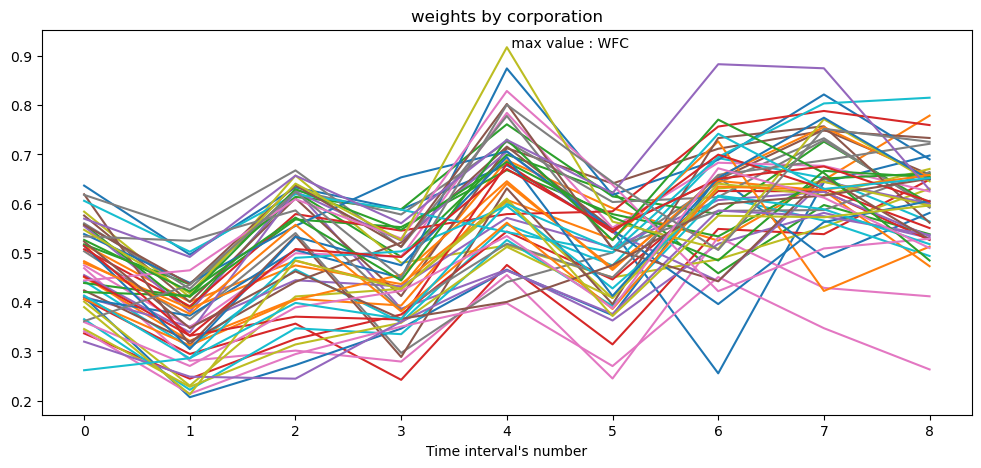

In [17]:
ax=dfweights.plot(legend=False,title='weights by corporation',figsize=(12,5))
ax.text(4,dfweights.max(axis=0).max()," max value : "+f"{dfweights.max(axis=0).idxmax()}")
ax.set_xlabel("Time interval's number")

Returns of portfolio

In [18]:
%%time
for t in df_50best.index:
    df_50best.loc[t,"portfolio returns - tracking error strategy"]=sum(dfweights[c].mean()*df_50best.loc[t,f"Return {c}"] for c in dfweights.columns)/len(dfweights.columns)

Wall time: 4.73 s


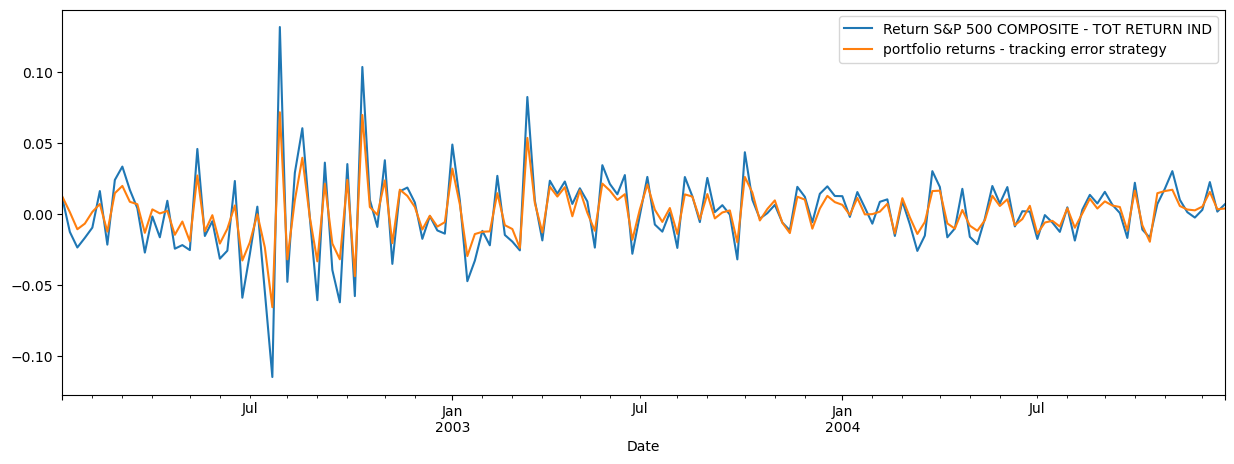

In [19]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
df_sp.loc[(df_sp.index<'2005')&(df_sp.index>'2002')].plot(y='Return S&P 500 COMPOSITE - TOT RETURN IND',ax=ax)
df_50best.loc[(df_50best.index<'2005')&(df_50best.index>'2002')].plot(y='portfolio returns - tracking error strategy',ax=ax)
plt.show()

Results - Tracking Error strategy

In [20]:
print(f"Expected return = {df_50best['portfolio returns - tracking error strategy'].mean()}\nAnnualized volatility = {annualized_volatility(df_50best['portfolio returns - tracking error strategy'],52)}\nSharpe ratio = {sharpe_ratio(df_50best['portfolio returns - tracking error strategy'],0,52)}\nTracking Error = {tracking_error(df_50best['portfolio returns - tracking error strategy'],df_sp['Return S&P 500 COMPOSITE - TOT RETURN IND'])}")

Expected return = 0.0018565057693640046
Annualized volatility = 0.10528583292093245
Sharpe ratio = 0.017633006434571337
Tracking Error = 0.009802390365989544


### Weight search by minimizing variance

---

Optimization problem (matrix form):  
$$\min W^T.C.W$$
s.t.
$$A.W - B <= 0$$

with :
- $W$ weight matrix
- $C$ covariance matrix
- $A$ matrix of emissions divided by market values
- $B$ matrix of the half carbonfootprint of portfolio

In [21]:
R=np.transpose(df_50best[df_50best.columns[int(len(df_50best.columns)/2):100]].to_numpy()) #returns matrix
C=np.cov(R) #covariance matrix

In [22]:
num_assets = 50

# Define the objective function to minimize (the portfolio variance)
def objective_function(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Set the initial guess for the weights (equal weights)
weights_0 = np.ones(num_assets) / num_assets

# Define the constraint function (the sum of the weights must be 1 and carbon footprint reduced of 50%)
constraint1 = LinearConstraint(np.ones(num_assets), [1], [1])
constraint2=LinearConstraint((df_carbonfootprint.loc[df_50best.columns[:int(len(df_50best.columns)/2)],'EMISSIONS']/
                              df_carbonfootprint.loc[df_50best.columns[:int(len(df_50best.columns)/2)],'MARKET_VALUE']).to_numpy()
                             -(0.5*df_carbonfootprint.loc[df_50best.columns[:int(len(df_50best.columns)/2)],'CARBON_FOOTPRINT']).to_numpy(),ub=[0])

solution = minimize(objective_function, weights_0, args=(C,), constraints=[constraint1,constraint2], bounds=[(0,1)]*num_assets)
weights_v=solution.x
# Print the solution (the optimal weights)
print("Optimal weights:", weights_v)

Optimal weights: [1.12873647e-18 1.83768388e-02 1.36137310e-18 2.16936372e-02
 2.11399410e-02 5.04044771e-02 1.81583883e-02 2.88795372e-19
 2.00705515e-04 5.28501753e-02 1.23545004e-02 5.02593529e-02
 0.00000000e+00 1.97201963e-21 0.00000000e+00 3.84509660e-19
 1.19437468e-18 4.25602658e-03 2.03510779e-02 1.46497875e-18
 7.22869221e-02 5.65791092e-18 1.51050248e-18 2.72135233e-02
 0.00000000e+00 6.35906471e-02 2.59569796e-18 5.08337077e-02
 6.83355791e-19 4.49481040e-02 2.49819715e-18 3.97744520e-02
 5.90706809e-19 4.47003403e-02 3.07803185e-18 2.60138162e-18
 1.80216806e-18 5.82235329e-02 1.28450645e-18 1.83087539e-18
 4.96662549e-02 5.17827630e-02 4.80431805e-02 3.15688590e-18
 6.03730348e-02 4.22940825e-02 9.60291675e-19 2.73416113e-02
 4.88827227e-02 1.48132263e-18]


In [23]:
dfweights_v=pd.DataFrame(weights_v)

In [24]:
%%time
df_50best["portfolio returns - variance strategy"]=""
for t in range(len(df_50best.index)):
    df_50best.iloc[t,101]=sum(dfweights_v.iloc[i,0]*df_50best[df_50best.columns[int(len(df_50best.columns)/2)-1:100]].iloc[t,i] for i in range(len(dfweights_v.index)))

Wall time: 24.7 s


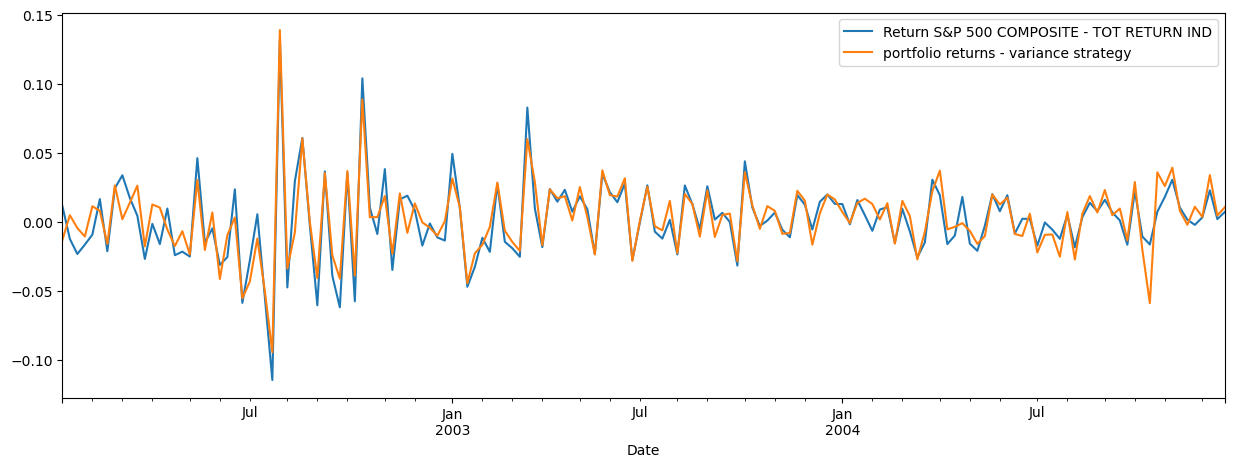

In [25]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
df_sp.loc[(df_sp.index<'2005')&(df_sp.index>'2002')].plot(y='Return S&P 500 COMPOSITE - TOT RETURN IND',ax=ax)
#df_50best.loc[(df_50best.index<'2005')&(df_50best.index>'2002')].plot(y='portfolio returns - tracking error strategy',ax=ax)
df_50best.loc[(df_50best.index<'2005')&(df_50best.index>'2002')].plot(y='portfolio returns - variance strategy',ax=ax)
plt.show()

Variance strategy - Results

In [26]:
print(f"Expected return = {df_50best['portfolio returns - variance strategy'].mean()}\nAnnualized volatility = {annualized_volatility(df_50best['portfolio returns - variance strategy'],52)}\nSharpe ratio = {sharpe_ratio(df_50best['portfolio returns - variance strategy'],0,52)}\nTracking Error = {tracking_error(df_50best['portfolio returns - variance strategy'],df_sp['Return S&P 500 COMPOSITE - TOT RETURN IND'])}")

Expected return = 0.003316113691453716
Annualized volatility = 0.15675233909416417
Sharpe ratio = 0.02115511456235216
Tracking Error = 0.010233572039230969


---

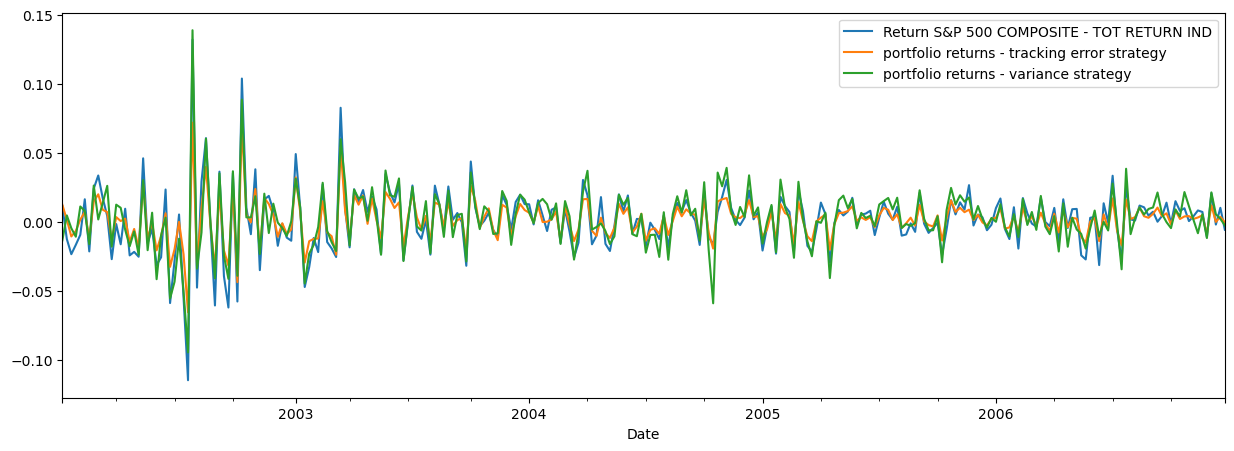

In [27]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
df_sp.loc[(df_sp.index<'2007')&(df_sp.index>'2002')].plot(y='Return S&P 500 COMPOSITE - TOT RETURN IND',ax=ax)
df_50best.loc[(df_50best.index<'2007')&(df_50best.index>'2002')].plot(y='portfolio returns - tracking error strategy',ax=ax)
df_50best.loc[(df_50best.index<'2007')&(df_50best.index>'2002')].plot(y='portfolio returns - variance strategy',ax=ax)
plt.show()